In [7]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import matplotlib.pyplot as plt
import dicom
import os
import scipy.ndimage
import cv2
import time
import scipy.misc
import caffe
import seaborn as sns
from IPython import display
import time 

caffe_root = "./"
%matplotlib inline

size_image = (120, 120, 1)
sns.set_style("whitegrid", {'axes.grid' : False})

plt.rcParams['image.cmap'] = 'gray'

rep_dataset = "/home/atemmar/Documents/Stage_ets/caffe-release_segmentation/dataSet_preprocess/"

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def normalize_heatmap(heatmap):
    heat_map_normalize = np.zeros(heatmap.shape)
    for x in range(heatmap.shape[0]):
        for y in range(heatmap.shape[1]):
            heat_map_normalize[x,y,:] = softmax(heatmap[x,y,:])
    
    return heat_map_normalize

def do_training(solver, step_size):
        solver.step(step_size)

        heat_map = solver.test_nets[0].blobs["score-final"].data[0,:,:,:].transpose(1,2,0)
        heat_map_normalize = normalize_heatmap(heat_map)
        minimum = np.min(heat_map[:,:,0])

        plt.figure(figsize=(10,10))
        image_test = solver.test_nets[0].blobs["data"].data[0].transpose(1,2,0)
        image_test_label = solver.test_nets[0].blobs["label"].data[0,0,:,:]
        plt.subplot(1,4,1)
        plt.imshow(image_test[:,:,0])
        plt.title("image test")
        plt.subplot(1,4,2)
        plt.imshow(image_test_label)
        plt.title("Label of the test image")
        plt.subplot(1,4,3)
        plt.imshow(heat_map_normalize)
        plt.title("min : " + str(minimum))
        plt.subplot(1,4,4)
        plt.imshow(solver.test_nets[0].blobs["score-final"].data[0,:,:,:].transpose(1,2,0).argmax(2), vmin=0, vmax=2)
        plt.title("After : " + str(nb_step+step_size) + " itterations")
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1)
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read training set

In [8]:
# rep_traininSet = "/home/luffy/Documents/Stage/dataSet_preprocess/Train/IRM/"
# rep_label = "/home/luffy/Documents/Stage/dataSet_preprocess/Train/Segment_GT/" 

rep_traininSet = rep_dataset + "/Train_croped/IRM/"
rep_label = rep_dataset + "/Train_croped/Segment_GT/" 

fileList = [f for f in list(os.walk(rep_traininSet))[0][2] if ".png" in f.lower()][:1000]

nb_image = 0
images_irm = np.zeros((size_image[0], size_image[1], size_image[2], len(fileList)))
labels = np.zeros((size_image[0], size_image[1], len(fileList)))
for filename in fileList:
    images_irm[:,:, 0,nb_image] = scipy.misc.imread(rep_traininSet + filename)
    labels[:,:, nb_image] = scipy.misc.imread(rep_label + filename)
    nb_image += 1
            

# Read test set

In [3]:
rep_testSet = rep_dataset + "/Test_croped/IRM/"
rep_label_test = rep_dataset + "/Test_croped/Segment_GT/" 

fileList = [f for f in list(os.walk(rep_testSet))[0][2] if ".png" in f.lower()]

nb_image = 0
images_irm_test = np.zeros((size_image[0], size_image[1], size_image[2], len(fileList)))
labels_test = np.zeros((size_image[0], size_image[1], len(fileList)))

for filename in fileList:
    images_irm_test[:,:, 0,nb_image] = scipy.misc.imread(rep_testSet + filename)
    labels_test[:,:, nb_image] = scipy.misc.imread(rep_label_test + filename)
    nb_image += 1
            

# Training alexnet

In [ ]:
caffe.set_device(0)
caffe.set_mode_gpu()
solver_name = caffe_root + "models/bvlc_alexnet_FCN_wTOPO/solver_alexnet_fcn_softmaxloss.prototxt"
solver = caffe.SGDSolver(solver_name)


# rep_model = "/media/luffy/DATA/Users/abdel/models_pretrained_rv_softmax/"
rep_model = "./"
weight_softmax = rep_model + 'train_alexnet_Topo_pretrained_softmax_iter_30000.caffemodel'
# solver_softmax = rep_model + 'train_alexnet_Topo_pretrained_softmax_iter_60000.solverstate'
# solver.restore(solver_softmax)
# solver.net.copy_from(weight_softmax)

solver.step(1)

image_test = solver.test_nets[0].blobs["data"].data[0].transpose(1,2,0)
image_test_label = solver.test_nets[0].blobs["label"].data[0,0,:,:]
plt.subplot(1,2,1)
plt.imshow(image_test[:,:,0])
plt.title("image test")
plt.subplot(1,2,2)
plt.imshow(image_test_label)
plt.title("Label of the test image")

nb_step = 0

In [ ]:
step_size = 500
for i in range(20*5):
    do_training(solver=solver, step_size=step_size)
    nb_step += step_size



In [17]:
# for each layer, show the output shape
for layer_name, blob in solver.net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 256, 216)
label	(1, 1, 256, 216)
data_data_0_split_0	(1, 3, 256, 216)
data_data_0_split_1	(1, 3, 256, 216)
conv1	(1, 96, 112, 102)
pool1	(1, 96, 56, 51)
norm1	(1, 96, 56, 51)
conv2	(1, 256, 56, 51)
pool2	(1, 256, 28, 25)
norm2	(1, 256, 28, 25)
conv3	(1, 384, 30, 27)
conv4	(1, 384, 30, 27)
conv5	(1, 256, 30, 27)
pool5	(1, 256, 15, 13)
fc6	(1, 4096, 10, 8)
fc7	(1, 4096, 10, 8)
score	(1, 3, 10, 8)
score-big	(1, 3, 351, 287)
score-final	(1, 3, 256, 216)
loss	()


# Training fcn perso

In [9]:
caffe.set_device(0)
caffe.set_mode_gpu()
solver_name = caffe_root + "models/fcn_perso/solver7_softmax.prototxt"
solver = caffe.SGDSolver(solver_name)

# for each layer, show the output shape
for layer_name, blob in solver.net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 1, 120, 120)
label	(1, 1, 120, 120)
data_data_0_split_0	(1, 1, 120, 120)
data_data_0_split_1	(1, 1, 120, 120)
conv1	(1, 32, 118, 118)
conv2	(1, 32, 116, 116)
pool1	(1, 32, 58, 58)
conv3	(1, 32, 56, 56)
conv4	(1, 32, 54, 54)
conv5	(1, 32, 52, 52)
conv6	(1, 32, 50, 50)
conv7	(1, 32, 48, 48)
conv8	(1, 32, 46, 46)
conv9	(1, 63, 46, 46)
score-big	(1, 3, 120, 120)
score-final	(1, 3, 120, 120)
loss	()


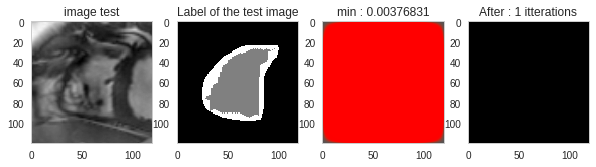

In [10]:
caffe.set_device(0)
caffe.set_mode_gpu()
solver_name = caffe_root + "models/fcn_perso/solver7_softmax.prototxt"
solver = caffe.SGDSolver(solver_name)


# rep_model = "/media/luffy/DATA/Users/abdel/models_pretrained_rv_softmax/"
rep_model = "/media/luffy/DATA/Users/abdel/models_pretrained_rv_softmax/perso1/"
weight_softmax = rep_model + 'train_perso4_Topo_pretrained_softmax_iter_232000.caffemodel'
# solver_softmax = rep_model + 'train_perso4_Topo_pretrained_softmax_iter_12000.solverstate'
# solver.restore(solver_softmax)
# solver.net.copy_from(weight_softmax)

# solver.step(1)


nb_step = 0
do_training(solver=solver, step_size=1)
# image_test = solver.test_nets[0].blobs["data"].data[0,0,:,:]
# image_test_label = solver.test_nets[0].blobs["label"].data[0,0,:,:]
# plt.subplot(1,2,1)
# plt.imshow(image_test)
# plt.title("image test")
# plt.subplot(1,2,2)
# plt.imshow(image_test_label)
# plt.title("Label of the test image")

value_loss = []

In [ ]:
solver.test_nets[0].blobs["label"].data.shape

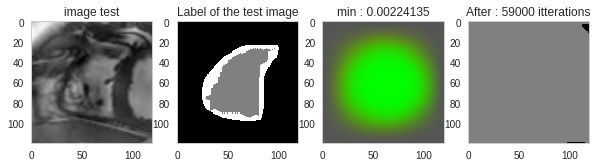

In [ ]:
step_size = 500
for i in range(20*10):
    do_training(solver=solver, step_size=step_size)
    nb_step += step_size
    value_loss.append(solver.test_nets[0].blobs["loss"].data)

In [14]:
solver.test_nets[0].blobs["score-final"].data

array([[[[  1.10478862e-03,   4.18738369e-03,   9.93054733e-03, ...,
            5.94186857e-02,   4.25759666e-02,   2.94032544e-02],
         [  4.87037329e-03,   1.92402136e-02,   4.59715351e-02, ...,
            2.70184606e-01,   1.93745539e-01,   1.34014890e-01],
         [  1.23858340e-02,   4.98264953e-02,   1.18069127e-01, ...,
            6.72845423e-01,   4.83033061e-01,   3.34907532e-01],
         ..., 
         [  9.83404815e-02,   3.87728631e-01,   8.00433278e-01, ...,
            3.85262156e+00,   2.90856838e+00,   2.04969358e+00],
         [  7.43518248e-02,   2.91422844e-01,   5.97175717e-01, ...,
            2.62253785e+00,   1.96488404e+00,   1.36795318e+00],
         [  5.37847728e-02,   2.09326535e-01,   4.24939752e-01, ...,
            1.58118367e+00,   1.16566014e+00,   7.91014671e-01]],

        [[  1.27957482e-03,   5.66023774e-03,   1.34842172e-02, ...,
            3.36160585e-02,   2.49268208e-02,   1.74399149e-02],
         [  4.93155885e-03,   2.22086236e-02,

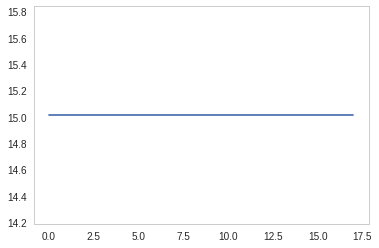

In [11]:
plt.plot(value_loss)

# Training FCN 32s

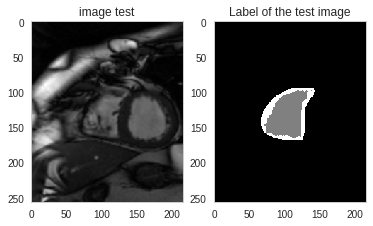

In [3]:
from IPython import display
import time 

caffe.set_device(0)
caffe.set_mode_cpu()
solver_name = caffe_root + "models/fcn32s/solver.prototxt"
solver = caffe.SGDSolver(solver_name)
# rep_model_fcn32s = caffe_root + "./models/fcn32s/"
rep_model_fcn32s = caffe_root + "./snapshot/train/fcn32s/"
# weight_32s = rep_model_fcn32s + 'pascalcontext-fcn32s-heavy.caffemodel'
# solver.net.copy_from(weight_32s)
solver_32s = rep_model_fcn32s + 'train_fcn32s_Topo_pretrained_softmaxloss_iter_8000.solverstate'
solver.restore(solver_32s)

solver.step(1)

image_test = solver.test_nets[0].blobs["data"].data[0].transpose(1,2,0)
image_test_label = solver.test_nets[0].blobs["label"].data[0,0,:,:]
plt.subplot(1,2,1)
plt.imshow(image_test[:,:,0])
plt.title("image test")
plt.subplot(1,2,2)
plt.imshow(image_test_label)
plt.title("Label of the test image")

nb_step = 0

In [ ]:
step_size = 500
for i in range(20*5):
    do_training(solver=solver, step_size=step_size)
    nb_step += step_size



In [7]:
solver.test_nets[0].blobs["score"].data[0,:,:,:].transpose(1,2,0).argmax(2)

array([[0, 1, 0, ..., 1, 0, 2],
       [1, 1, 2, ..., 1, 1, 2],
       [0, 2, 0, ..., 0, 2, 2],
       ..., 
       [2, 2, 0, ..., 0, 2, 2],
       [0, 2, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 2, 2, 0]])

In [3]:
# for each layer, show the output shape
for layer_name, blob in solver.net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 256, 216)
label	(1, 1, 256, 216)
data_data_0_split_0	(1, 3, 256, 216)
data_data_0_split_1	(1, 3, 256, 216)
conv1_1	(1, 64, 454, 414)
conv1_2	(1, 64, 454, 414)
pool1	(1, 64, 227, 207)
conv2_1	(1, 128, 227, 207)
conv2_2	(1, 128, 227, 207)
pool2	(1, 128, 114, 104)
conv3_1	(1, 256, 114, 104)
conv3_2	(1, 256, 114, 104)
conv3_3	(1, 256, 114, 104)
pool3	(1, 256, 57, 52)
conv4_1	(1, 512, 57, 52)
conv4_2	(1, 512, 57, 52)
conv4_3	(1, 512, 57, 52)
pool4	(1, 512, 29, 26)
conv5_1	(1, 512, 29, 26)
conv5_2	(1, 512, 29, 26)
conv5_3	(1, 512, 29, 26)
pool5	(1, 512, 15, 13)
fc6	(1, 4096, 9, 7)
fc7	(1, 4096, 9, 7)
score_fr	(1, 3, 9, 7)
upscore	(1, 3, 320, 256)
score	(1, 3, 256, 216)
loss	()


# RESULTS

In [10]:

caffe.set_device(0)
caffe.set_mode_gpu()
model_def = caffe_root + 'models/bvlc_alexnet_FCN_wTOPO/my_alexnet_fcn_deploy.prototxt'
# model_weights = caffe_root + 'models/bvlc_alexnet_FCN_wTOPO/alexnet_LT.caffemodel'
model_weights = caffe_root + 'train_alexnet_Topo_pretrained_softmax_iter_30000.caffemodel'


# net = caffe.Net(model_def,      # defines the structure of the model
#                 model_weights, caffe.TEST)     # use test mode (e.g., don't perform dropout)
net = solver.net


## Result on the training set

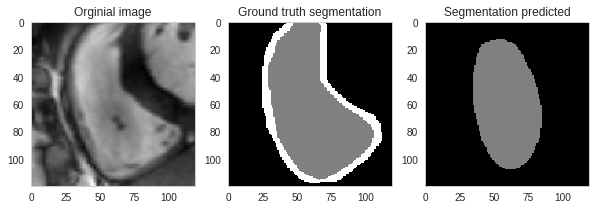

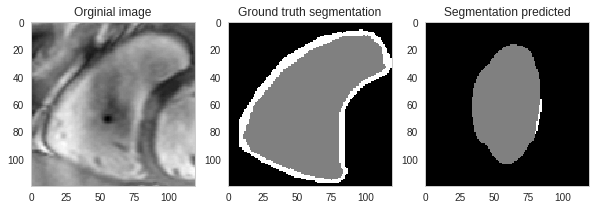

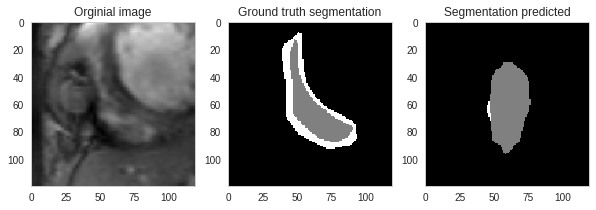

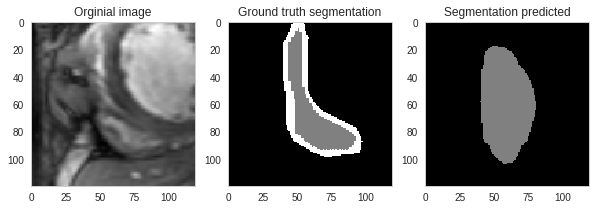

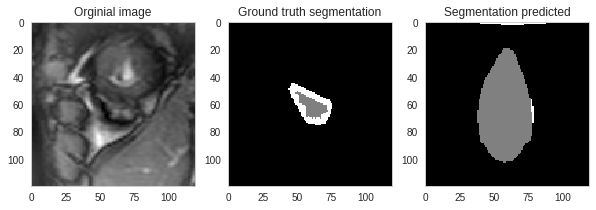

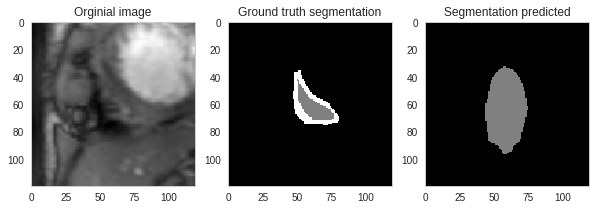

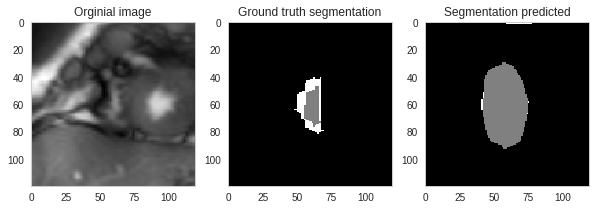

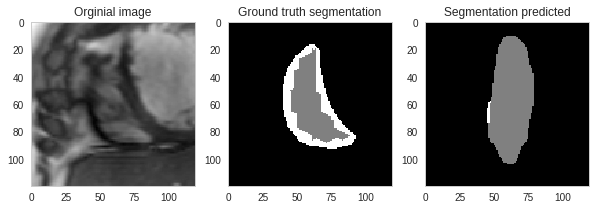

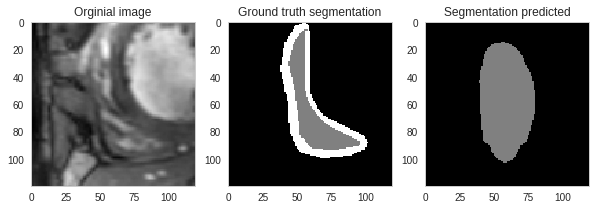

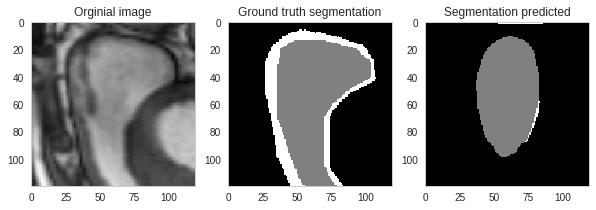

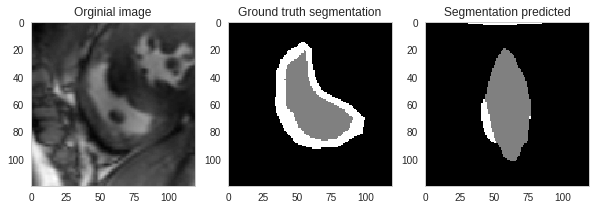

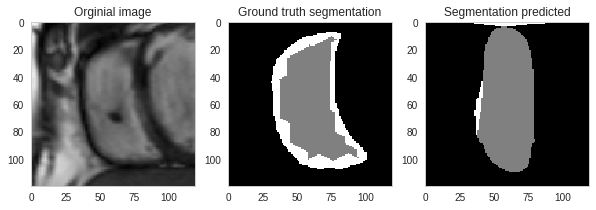

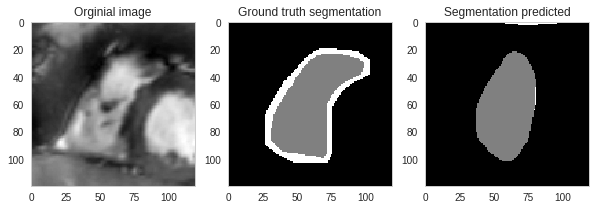

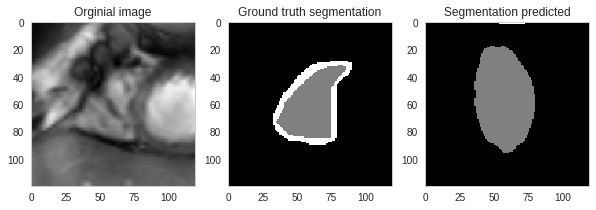

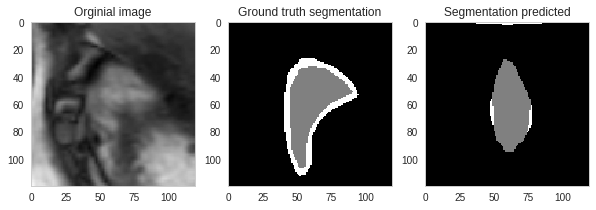

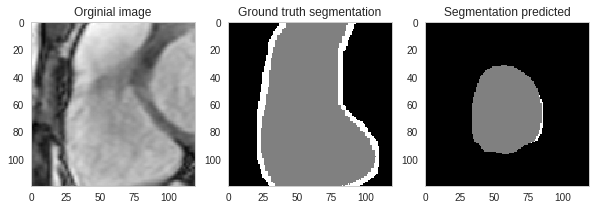

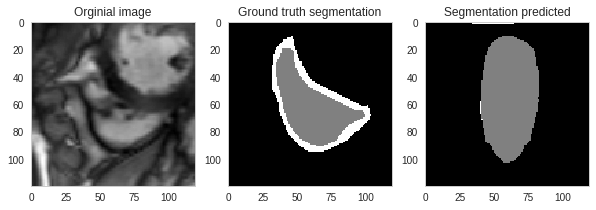

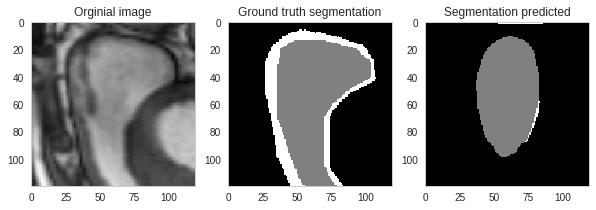

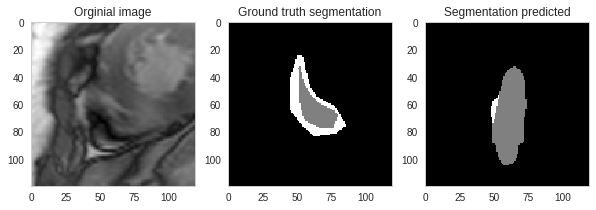

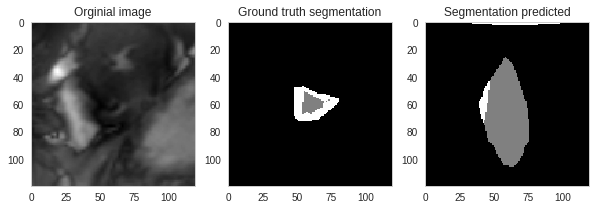

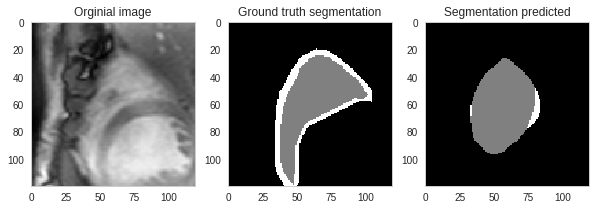

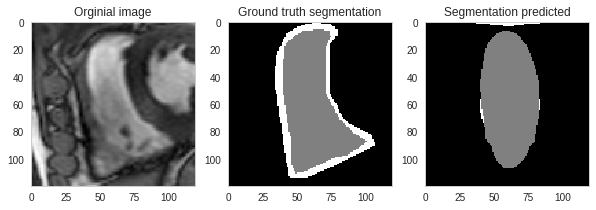

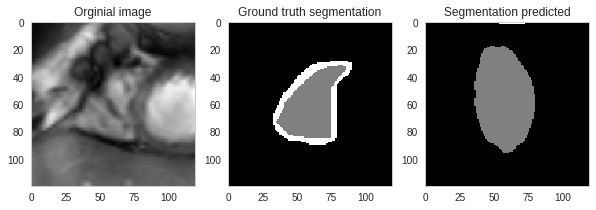

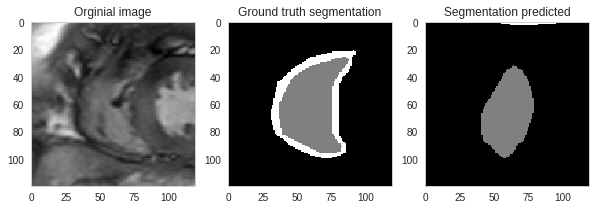

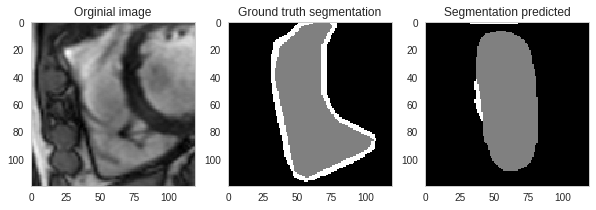

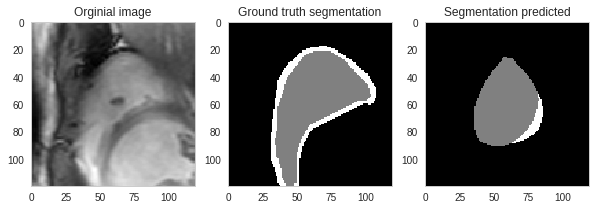

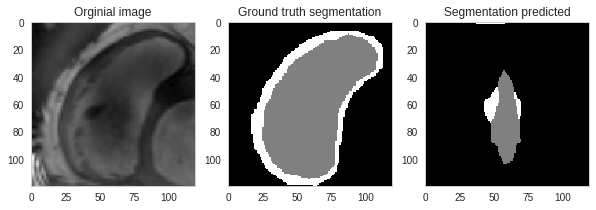

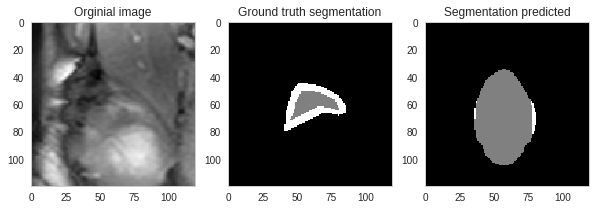

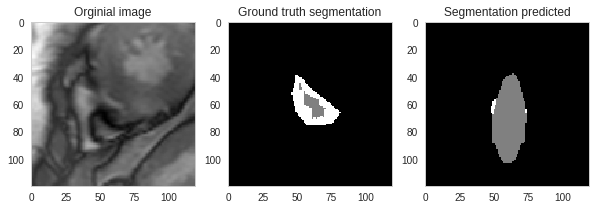

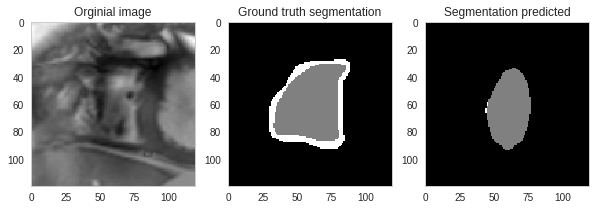

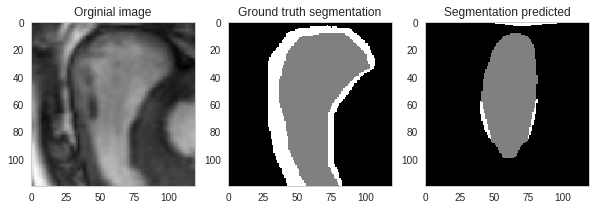

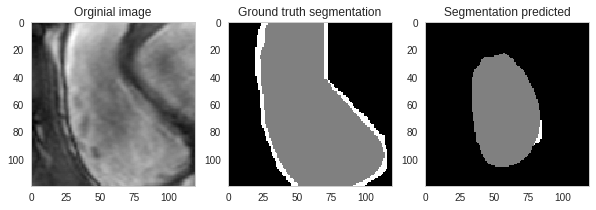

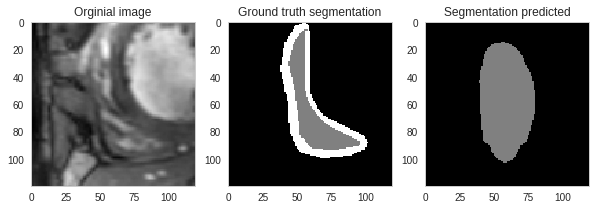

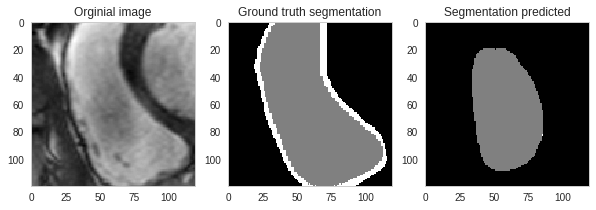

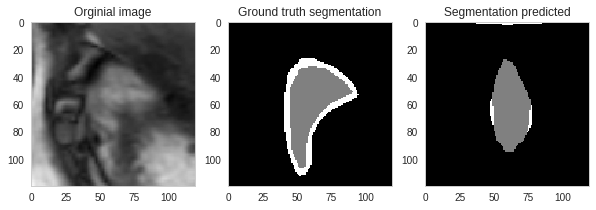

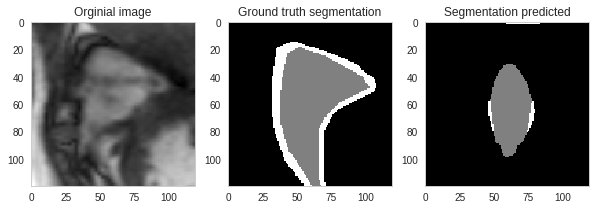

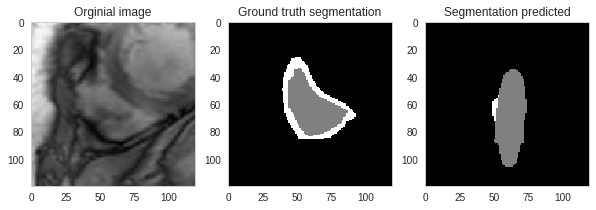

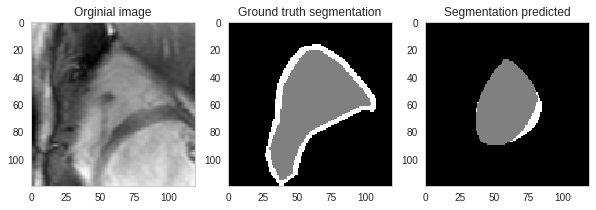

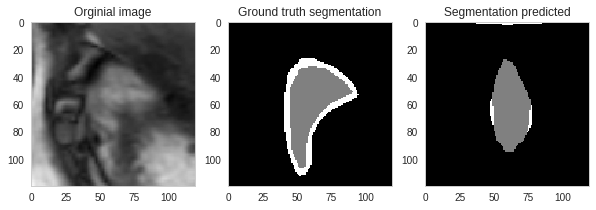

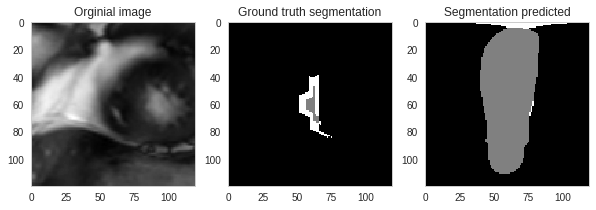

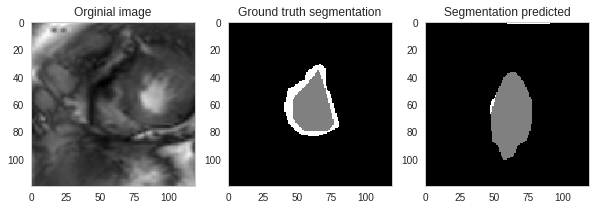

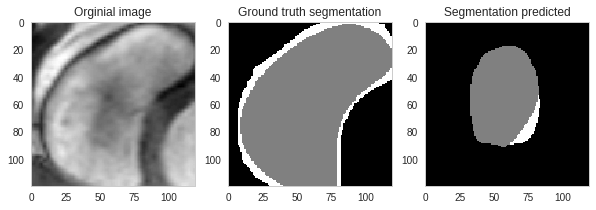

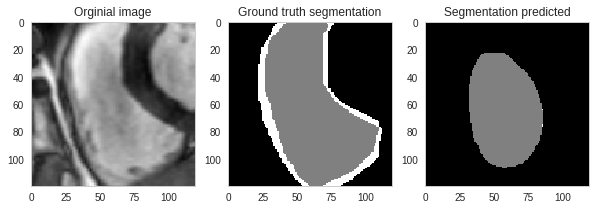

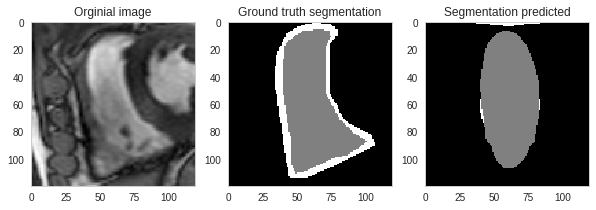

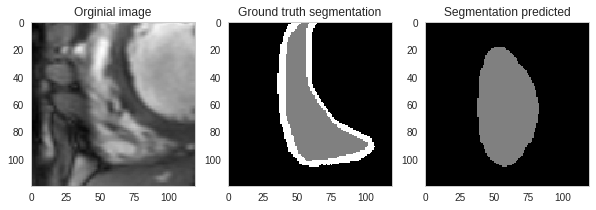

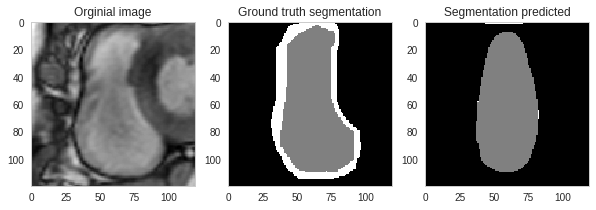

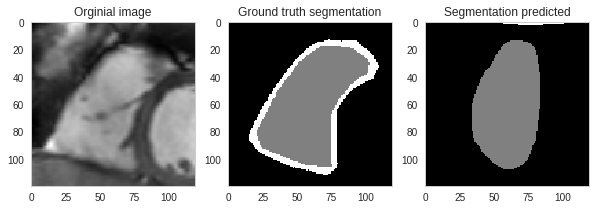

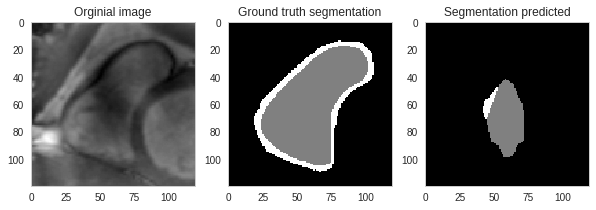

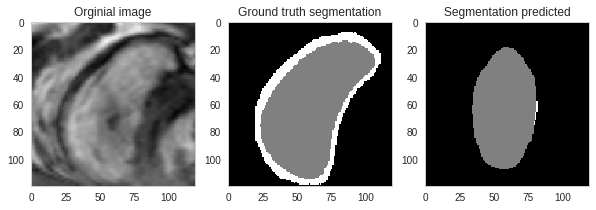

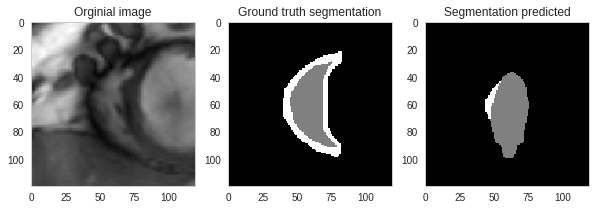

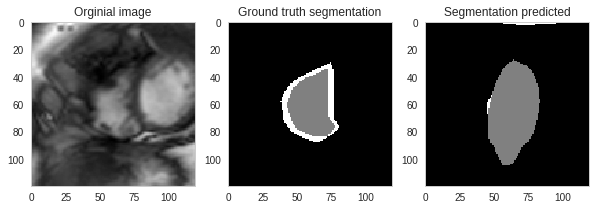

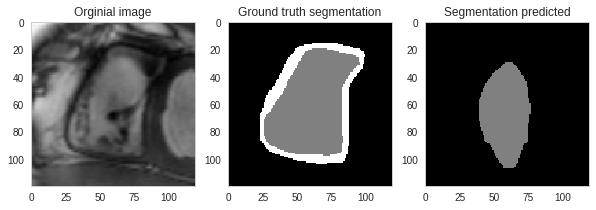

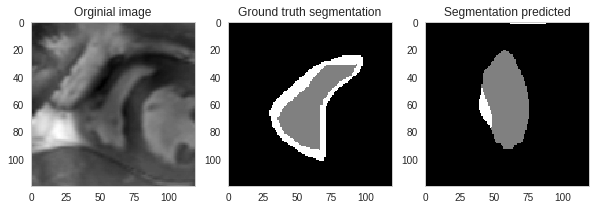

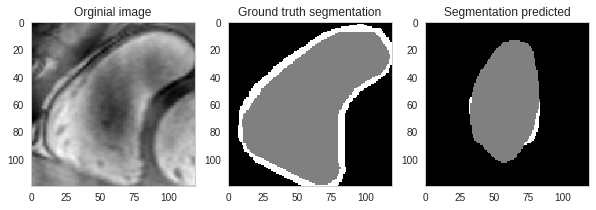

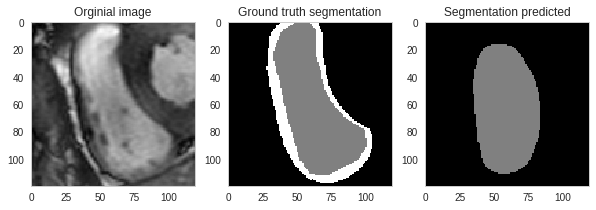

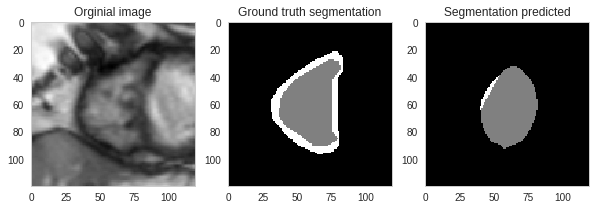

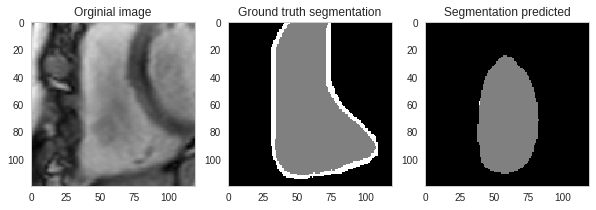

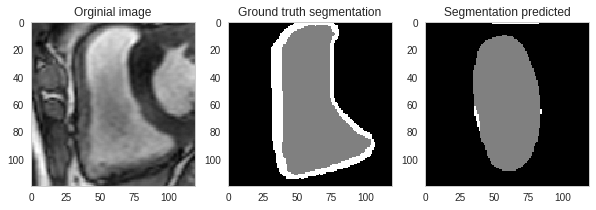

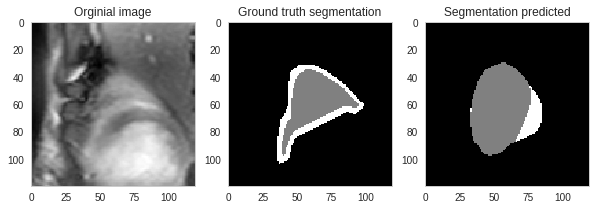

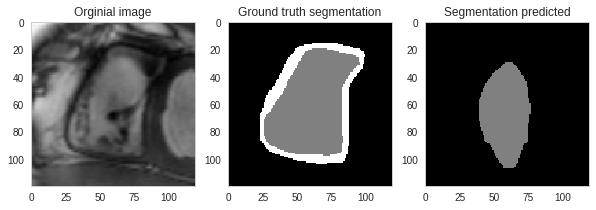

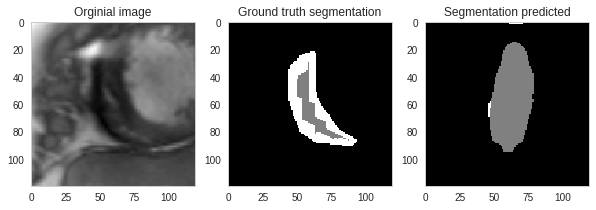

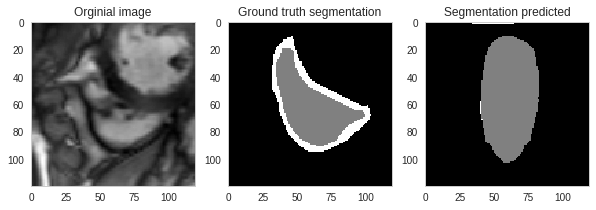

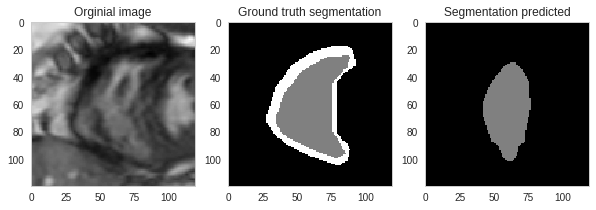

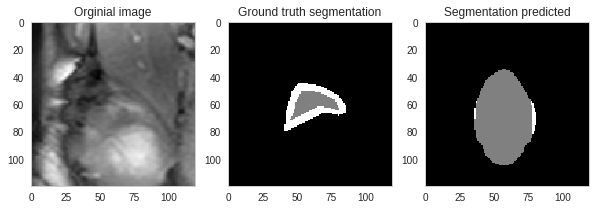

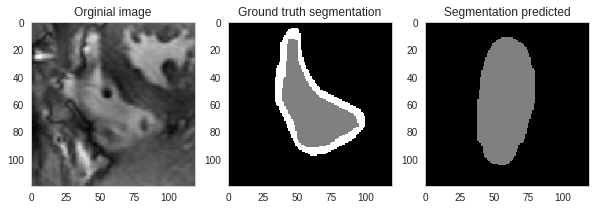

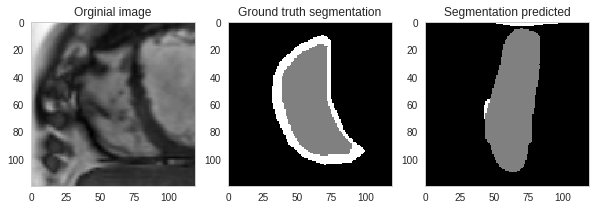

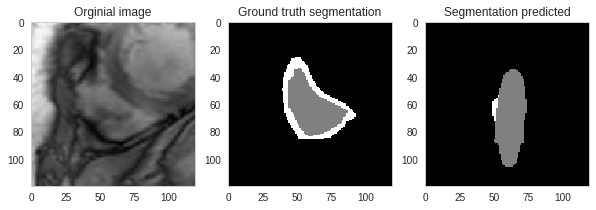

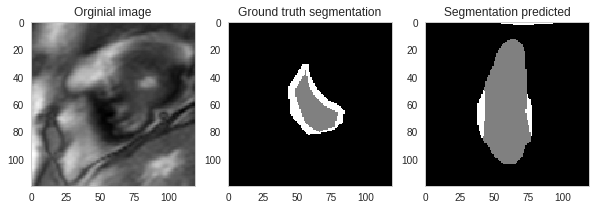

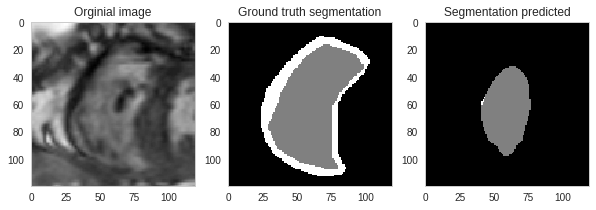

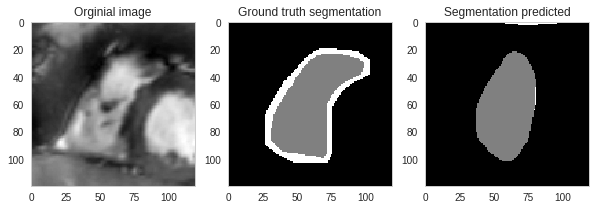

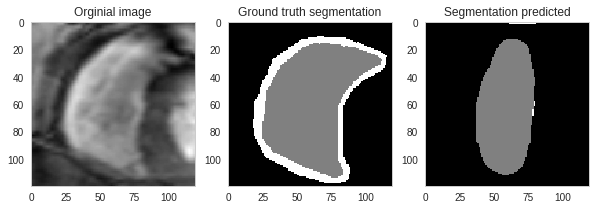

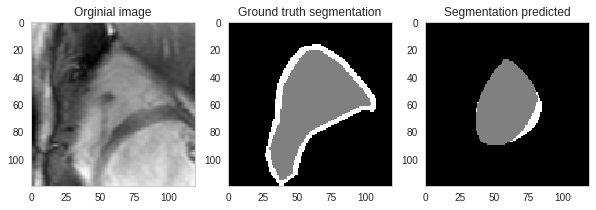

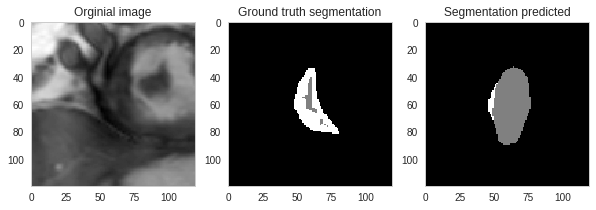

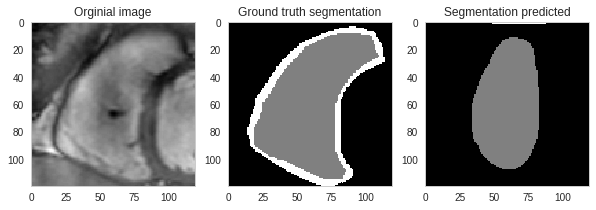

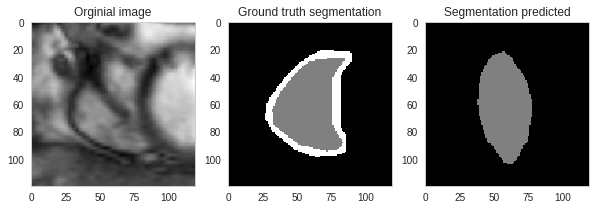

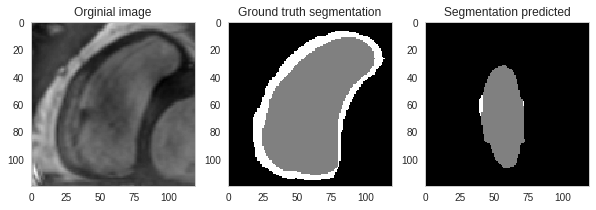

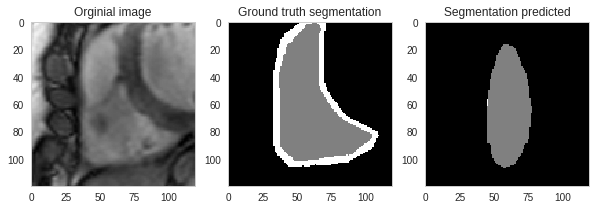

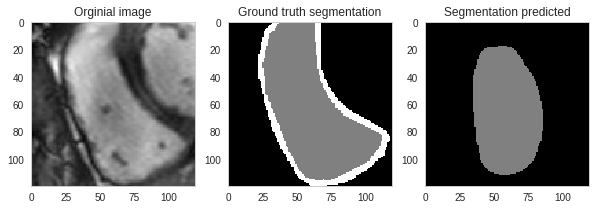

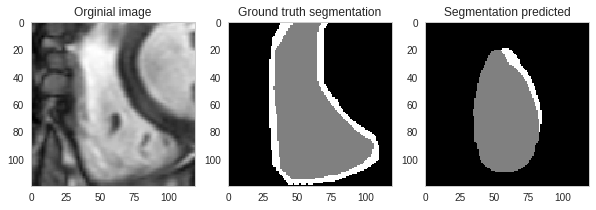

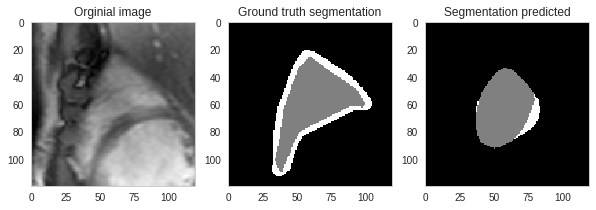

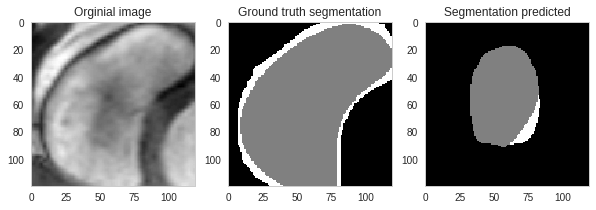

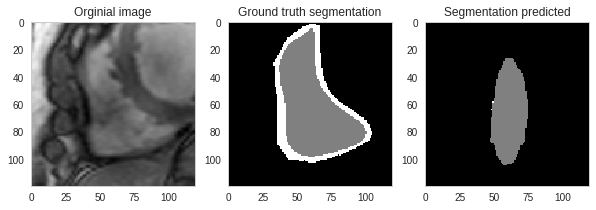

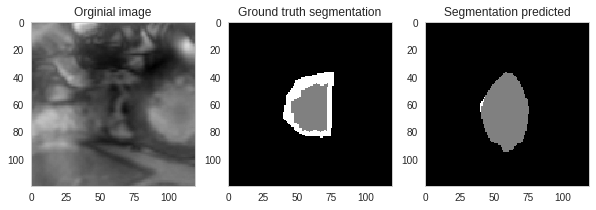

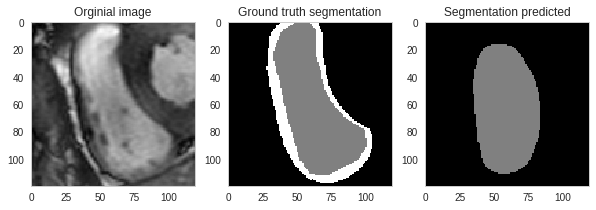

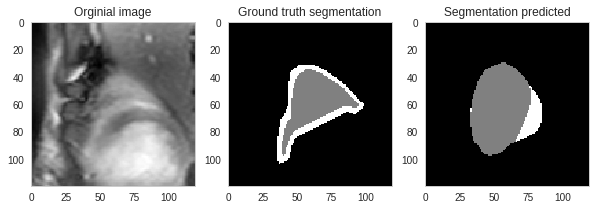

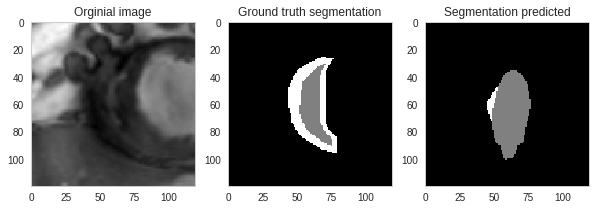

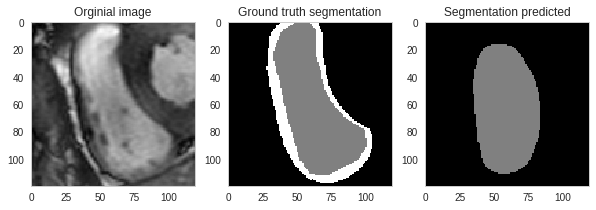

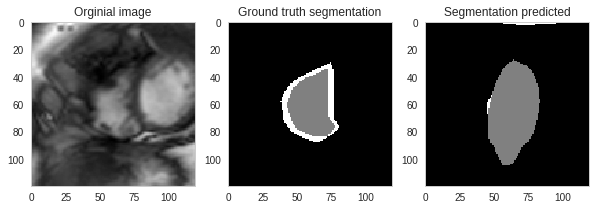

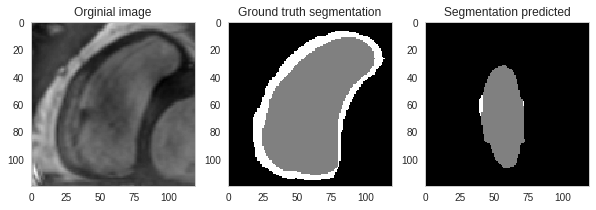

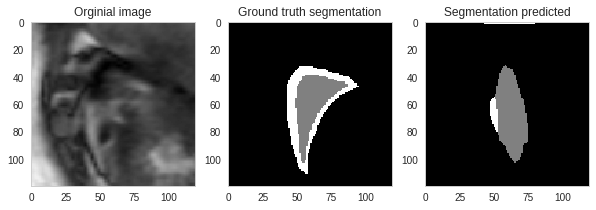

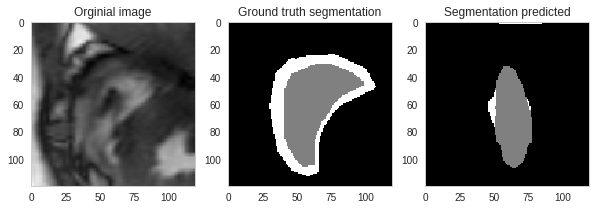

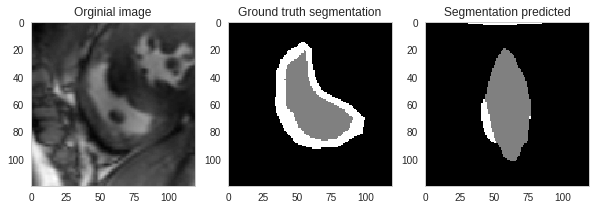

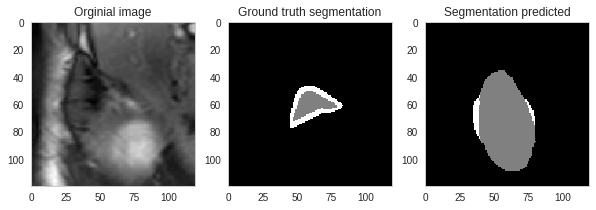

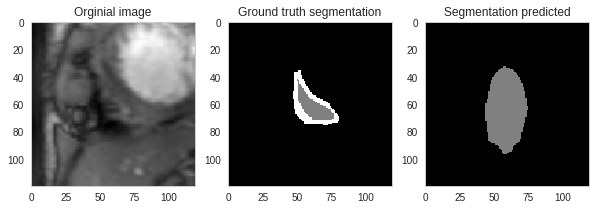

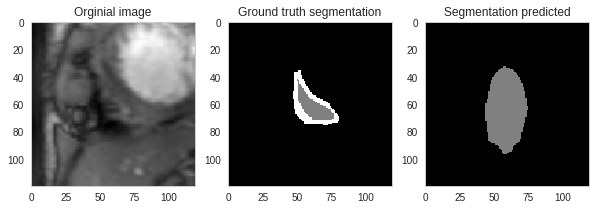

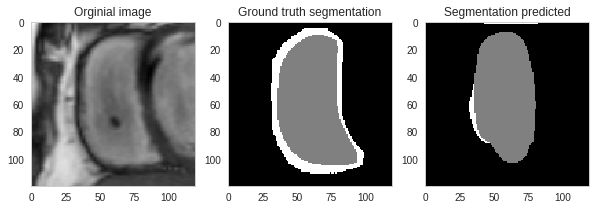

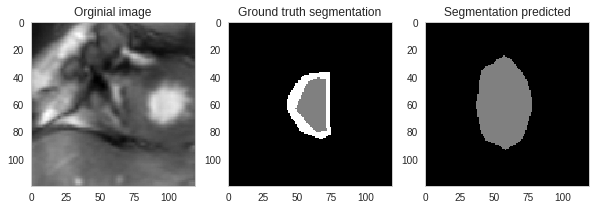

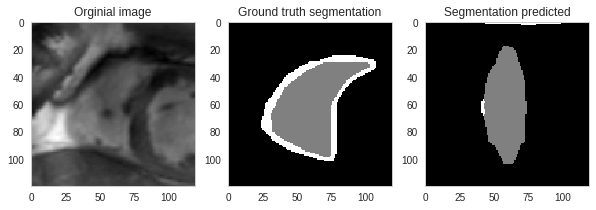

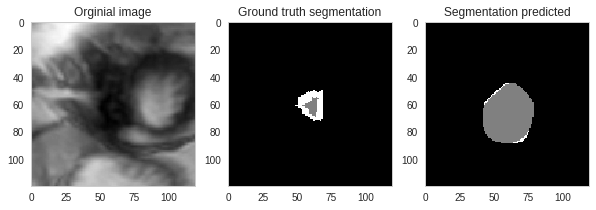

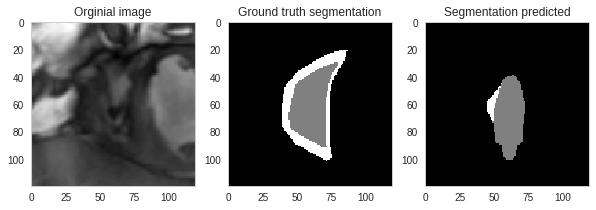

In [11]:
import random

nb_images = images_irm.shape[3]
indices = list(range(nb_images))
images_to_test = indices[:100]

for num_image_train in images_to_test:
    img = images_irm[:,:,:,num_image_train].transpose(2,0,1)
    label = labels[:,:, num_image_train]

    net.blobs['data'].data[...] = img
    net.forward()
    
    out = net.blobs["score-final"].data[0,:,:,:].transpose(1,2,0)
    label_out = out.argmax(axis=2)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.imshow(net.blobs['data'].data[0].transpose(1,2,0)[:,:,0])
    plt.title("Orginial image")
    plt.subplot(1,3,2)
    plt.imshow(net.blobs['label'].data[0,0,:,:], vmin=0, vmax=2)
    plt.title("Ground truth segmentation")
    plt.subplot(1,3,3)
    plt.imshow(label_out, vmin=0, vmax=2)
    plt.title("Segmentation predicted")

## Results on the test set

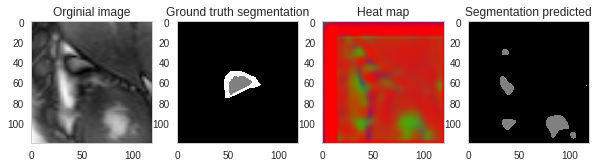

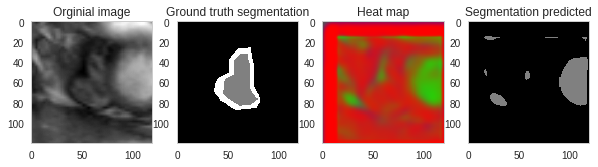

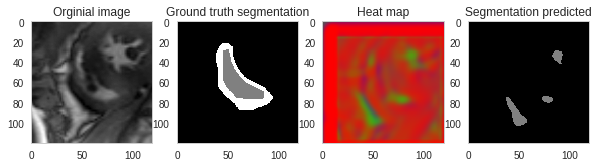

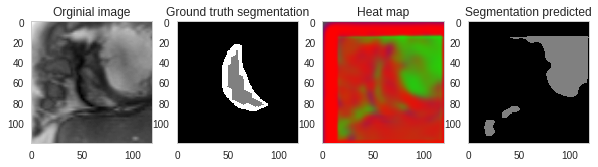

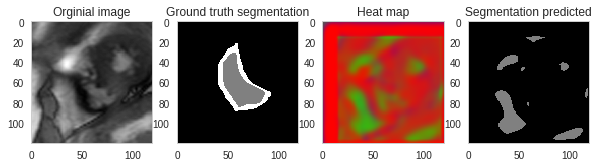

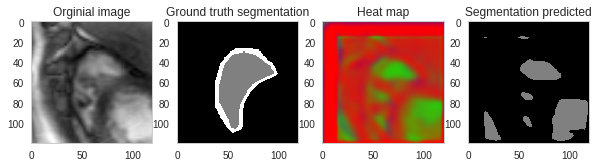

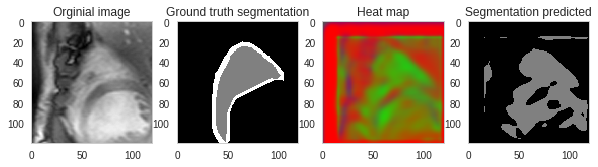

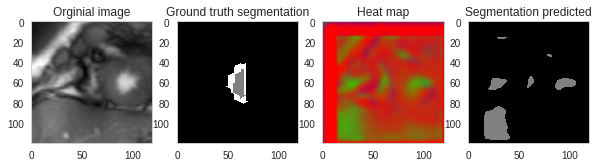

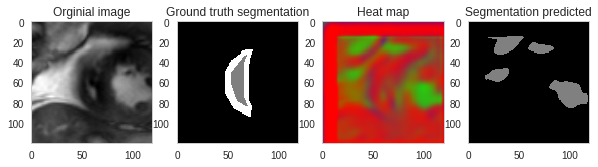

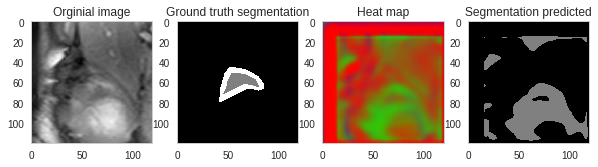

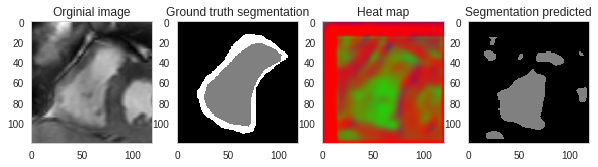

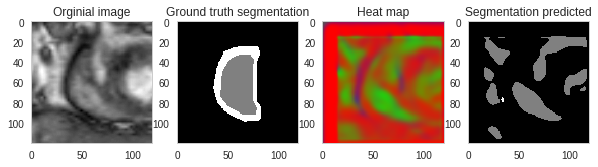

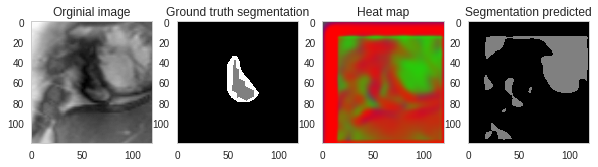

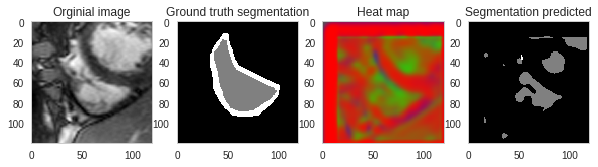

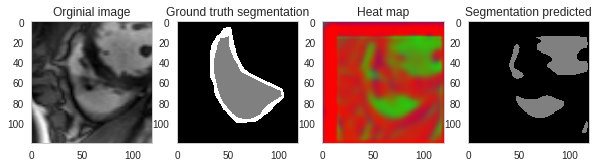

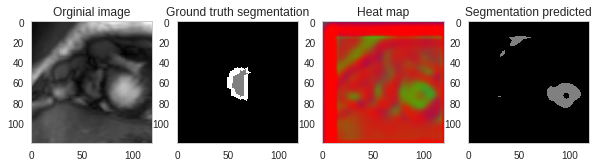

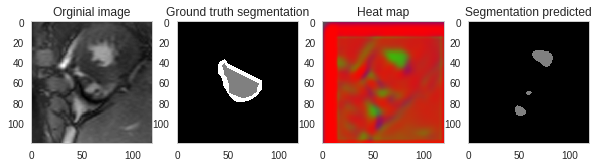

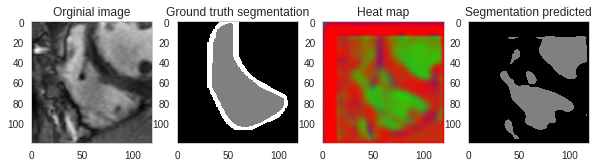

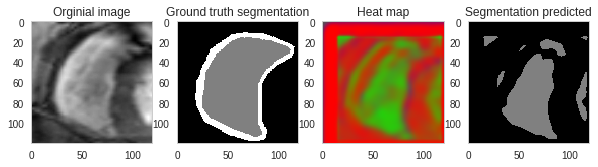

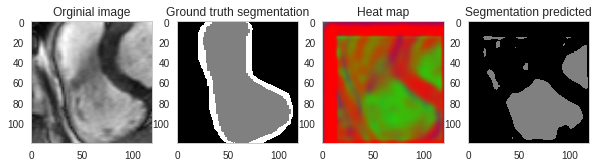

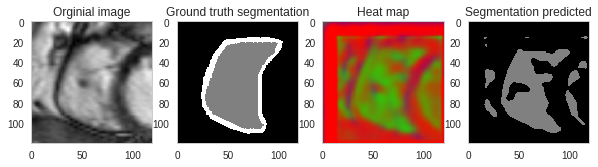

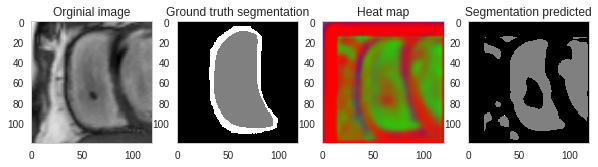

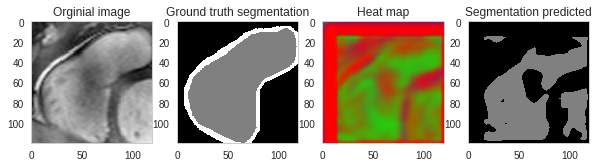

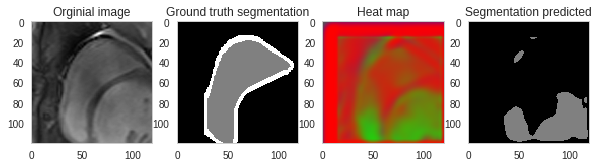

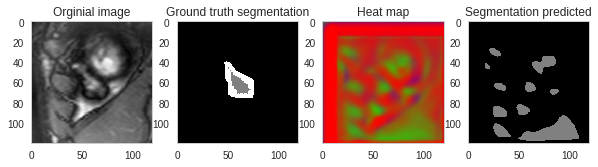

In [20]:
##### import random

nb_images = images_irm_test.shape[3]
indices = list(range(nb_images))
images_to_test = indices

for num_image_test in images_to_test:
    img = images_irm_test[:,:,:,num_image_test].transpose(2,0,1)
    label = labels_test[:,:, num_image_test]

    net.blobs['data'].data[...] = img
    net.forward()
    
    out = net.blobs["score-final"].data[0,:,:,:].transpose(1,2,0)
    label_out = out.argmax(axis=2)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(net.blobs['data'].data[0].transpose(1,2,0)[:,:,0])
    plt.title("Orginial image")
    plt.subplot(1,4,2)
    plt.imshow(net.blobs['label'].data[0,0,:,:], vmin=0, vmax=2)
    plt.title("Ground truth segmentation")
    plt.subplot(1,4,3)
    plt.imshow(normalize_heatmap(out))
    plt.title("Heat map")
    plt.subplot(1,4,4)
    plt.imshow(label_out, vmin=0, vmax=2)
    plt.title("Segmentation predicted")

ValueError: num must be 1 <= num <= 200, not 201

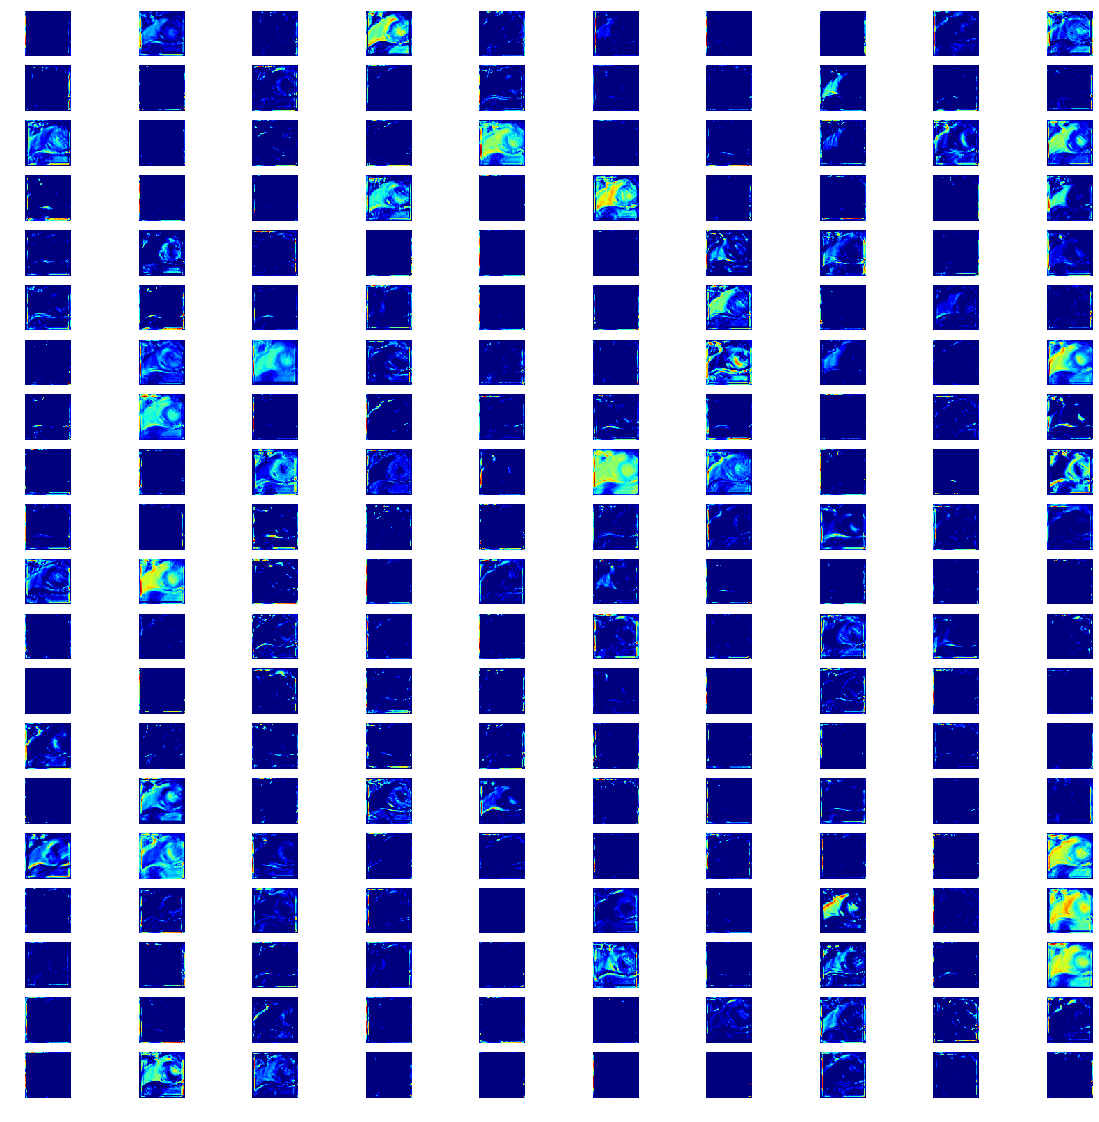

In [57]:
# the parameters are a list of [weights, biases]
conv1 = net.blobs['conv3'].data

# plt.figure(figsize=(30,30))
plt.figure(figsize=(20,20))
for i in range(conv1.shape[1]):
    plt.subplot(20,10,i+1)
#     plt.figure(figsize=(10,10))
    plt.imshow(conv1[0,i,:,:], cmap="jet")
    plt.axis('off')



In [33]:
net.blobs['score'].data.shape

(1, 3, 66, 66)

### Depending on the number of itterations done

#### Load all the nets

In [7]:
nb_itterations = [2000, 10000, 20000, 40000, 60000, 80000, 100000, 102000]

model_def = caffe_root + 'models/fcn_perso/fcn_perso4_softmaxloss.prototxt'
rep_model = "/media/luffy/DATA/Users/abdel/models_pretrained_rv_softmax/perso1/"

nets = []

solver_name = caffe_root + "models/fcn_perso/solver4_softmax.prototxt"
solver = caffe.SGDSolver(solver_name)

caffe.set_device(0)
caffe.set_mode_gpu()
for nb_itter in nb_itterations:
    model_solver = rep_model + 'train_perso4_Topo_pretrained_softmax_iter_' + str(nb_itter) +'.solverstate'
    solver.restore(model_solver)
    net = solver.net
#     net = caffe.Net(model_def,      # defines the structure of the model
#                 model_weights, caffe.TEST)     # use test mode (e.g., don't perform dropout)
    nets.append(net)

/home/luffy/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


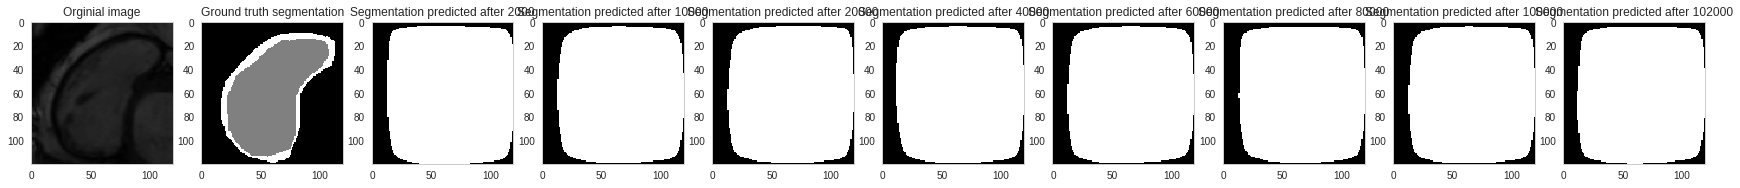

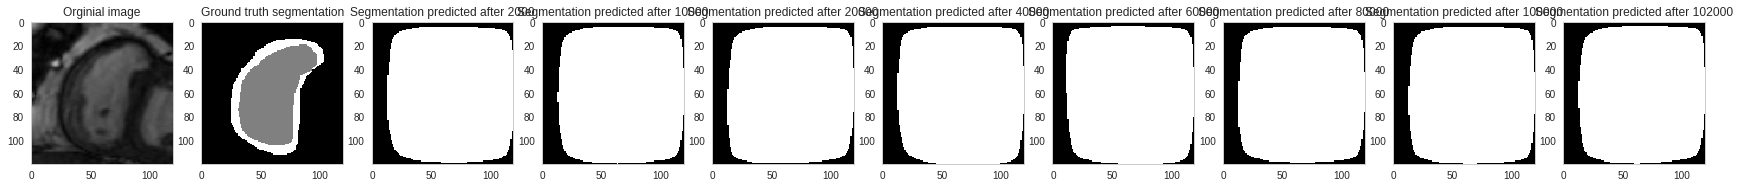

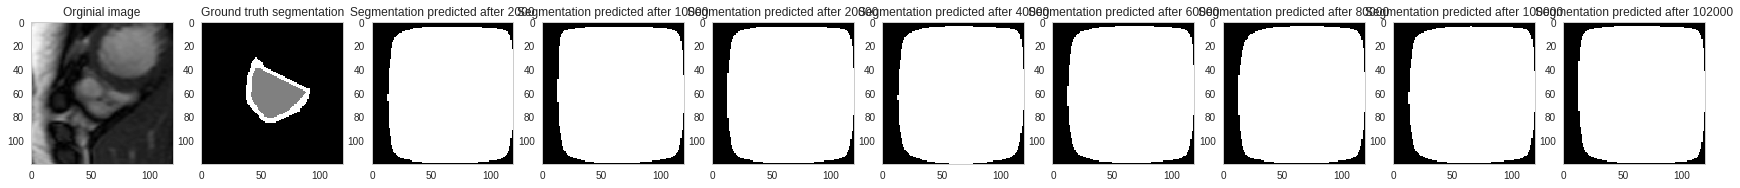

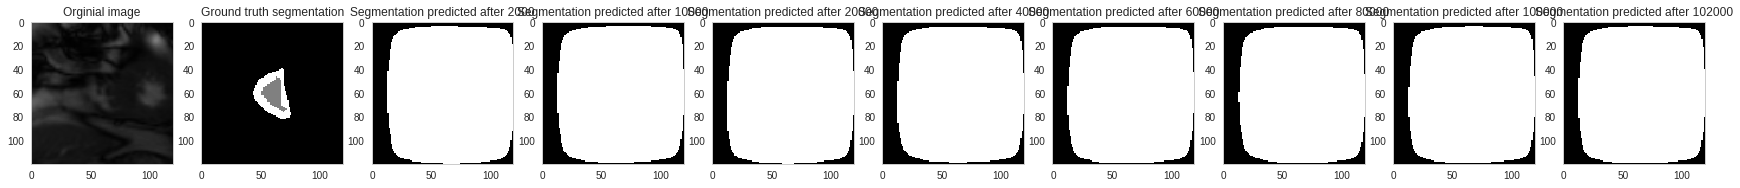

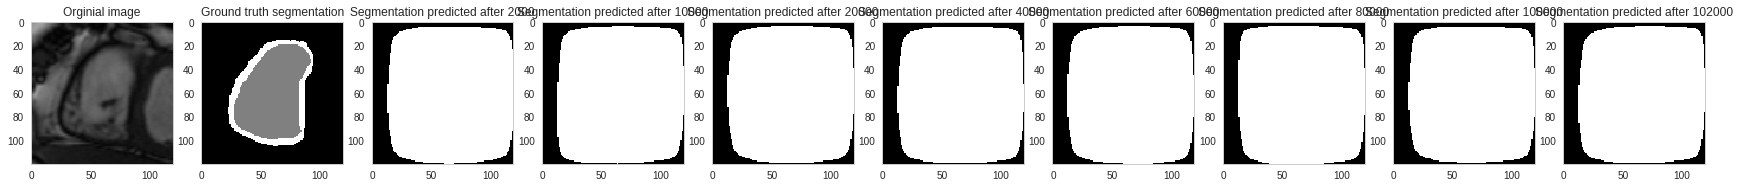

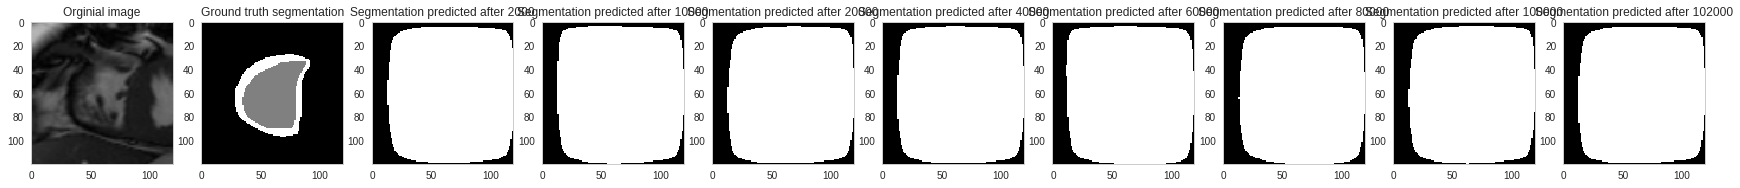

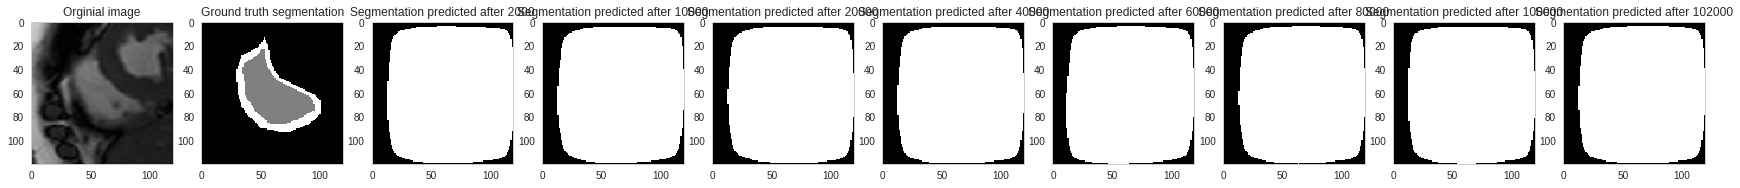

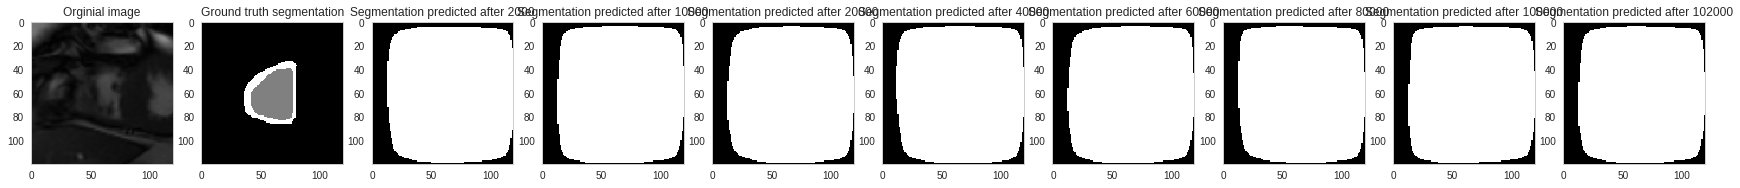

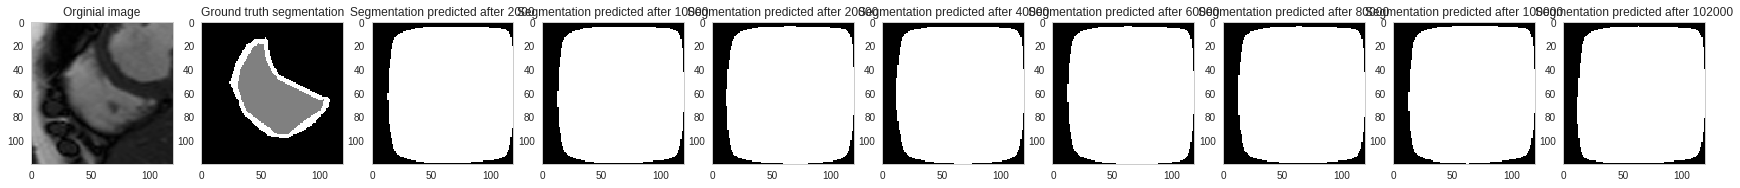

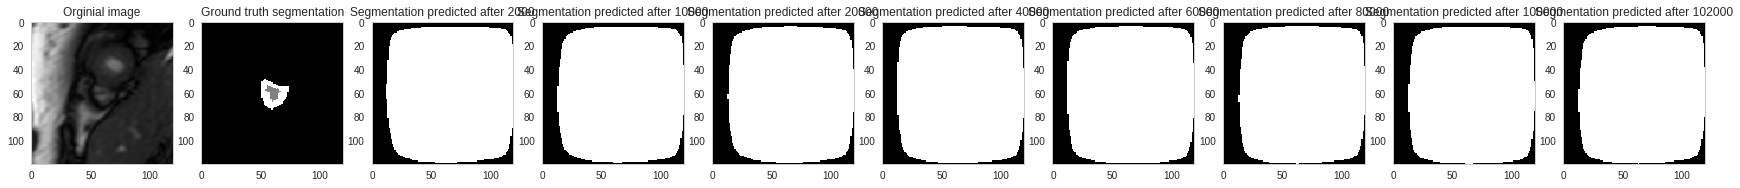

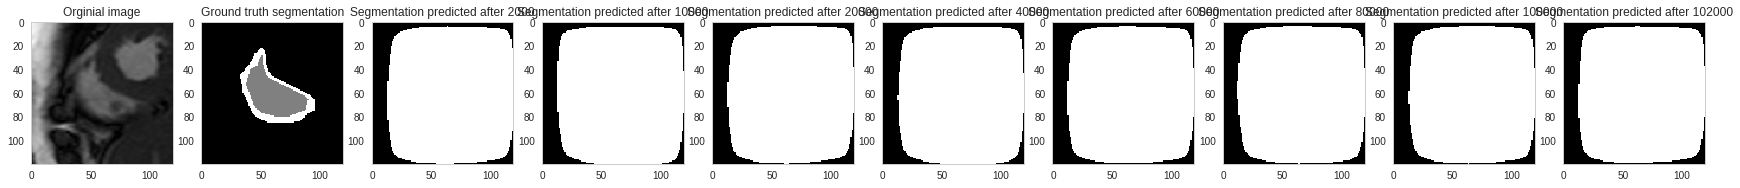

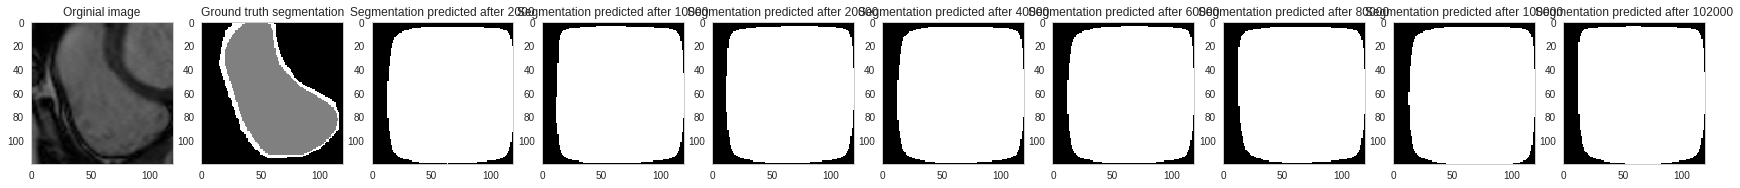

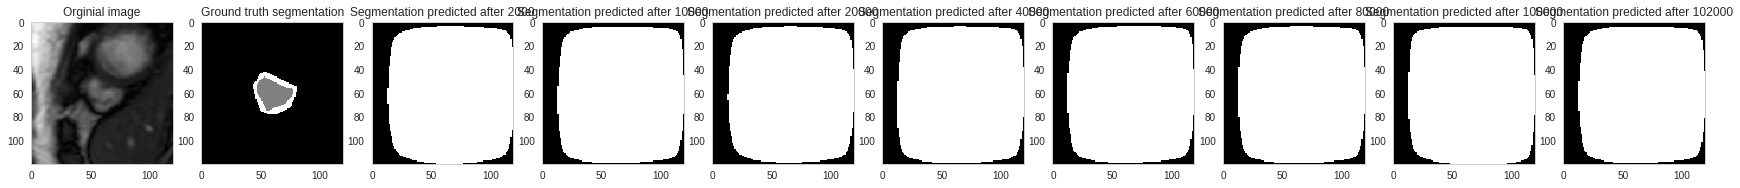

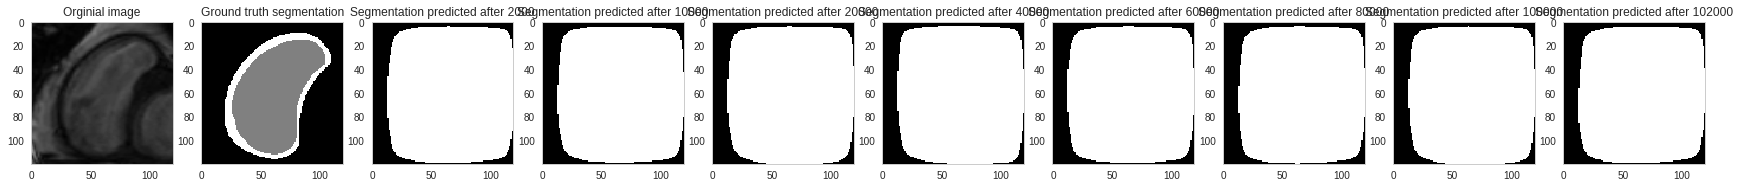

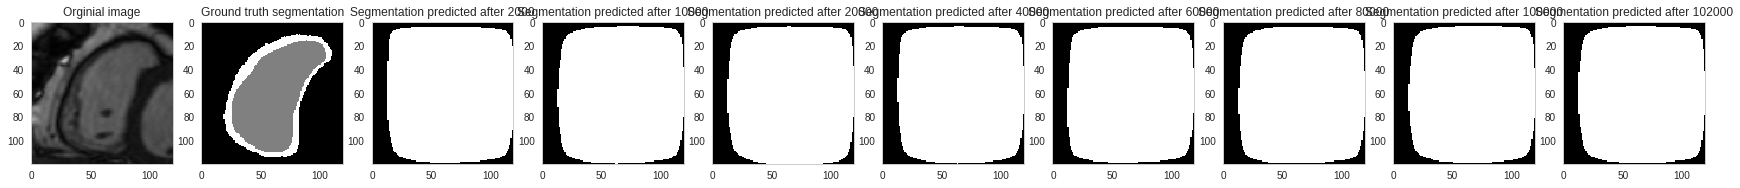

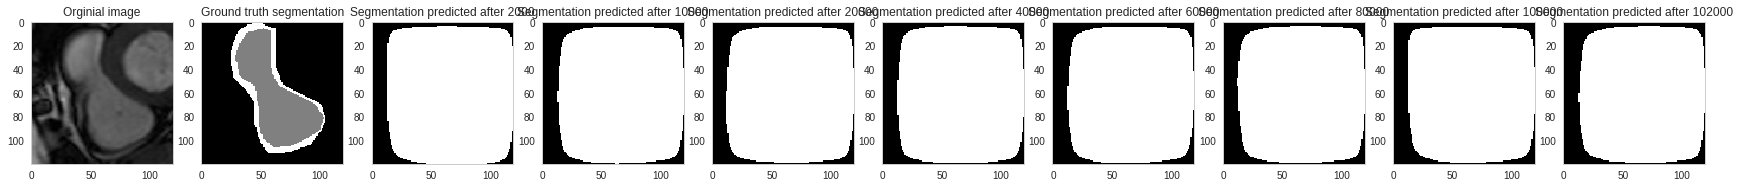

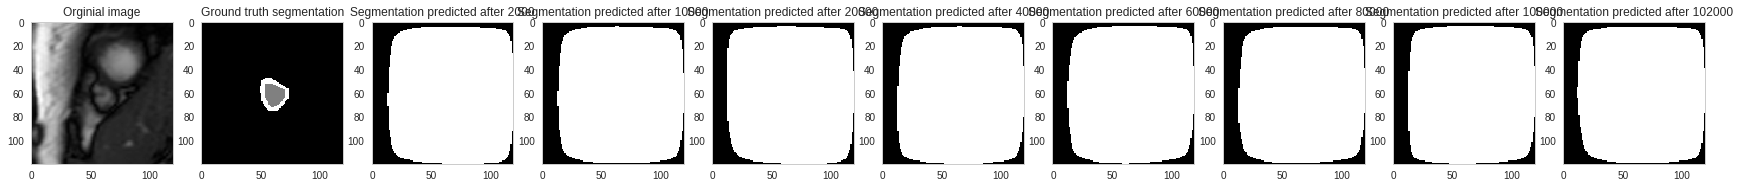

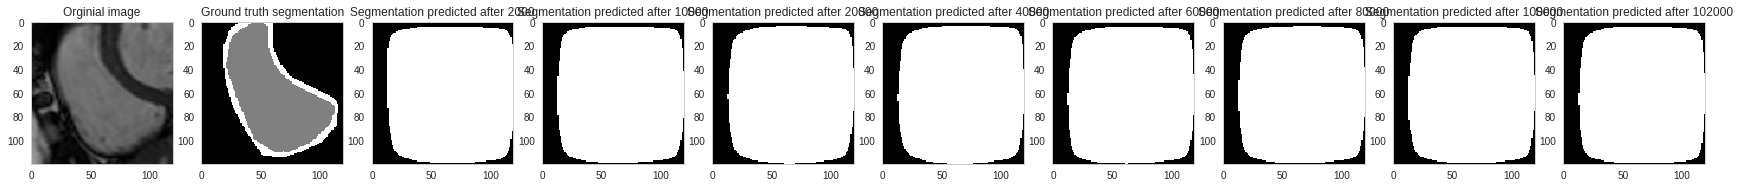

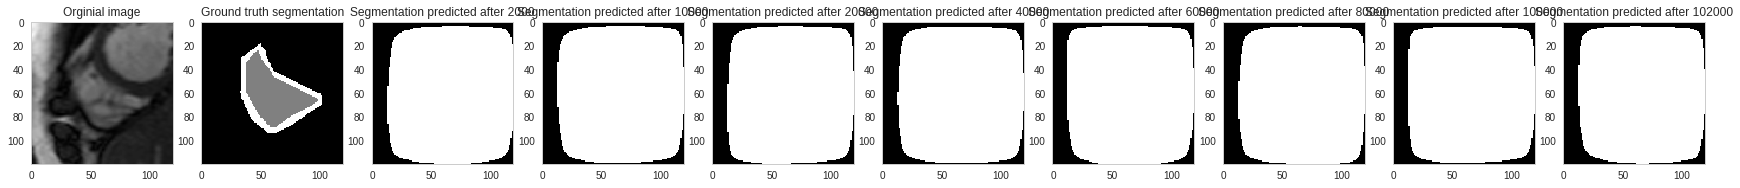

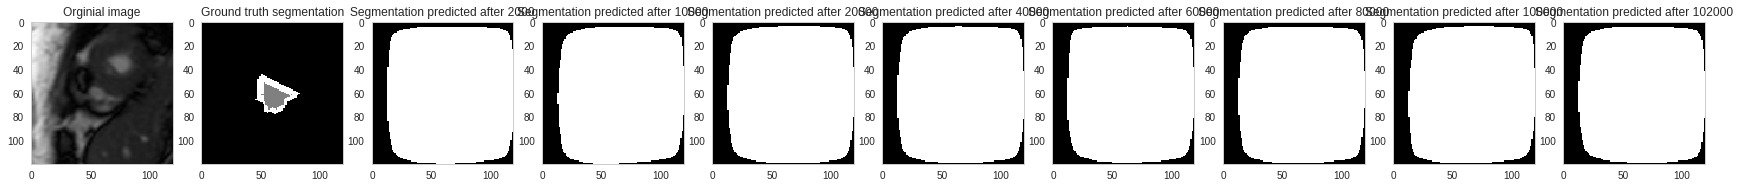

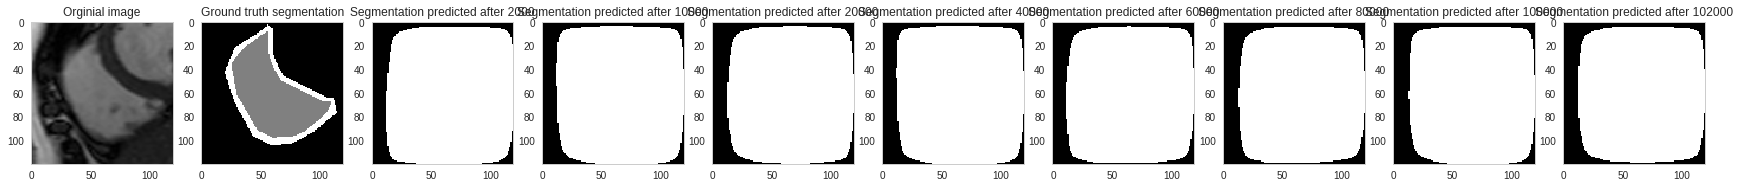

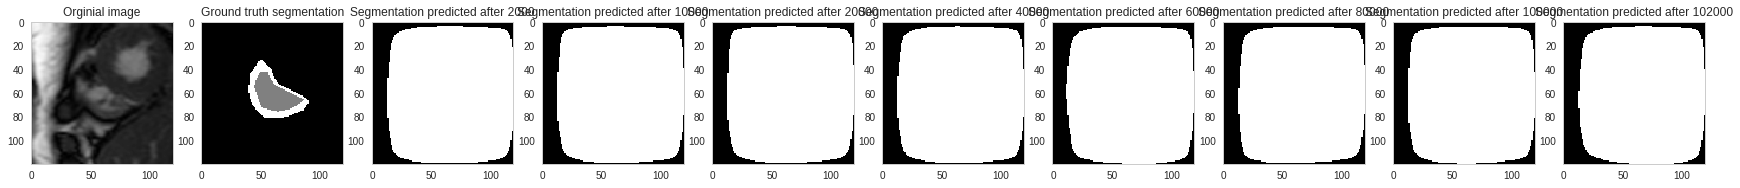

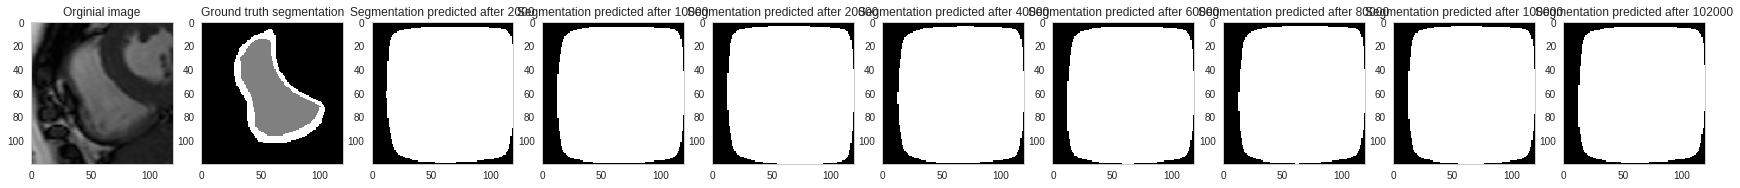

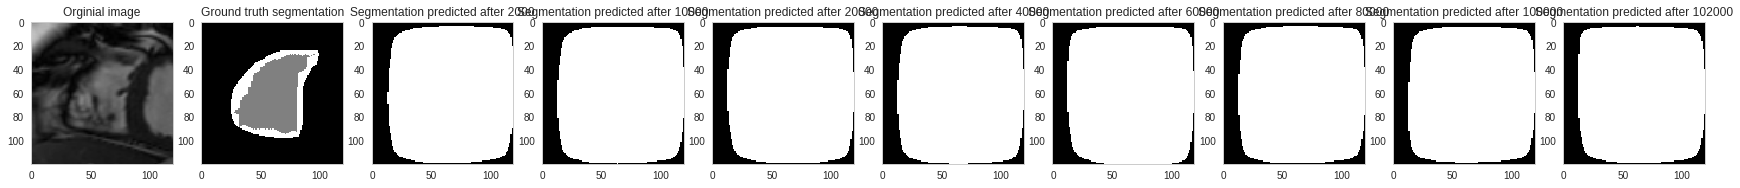

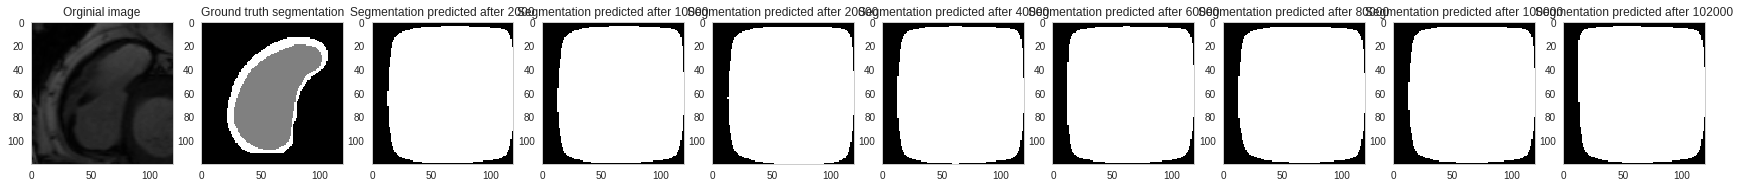

In [8]:
nbs_nets = len(nets)
nb_columns_display = 2 + nbs_nets

for num_image_test in range(images_irm_test.shape[3]):
    img = images_irm_test[:,:,:,num_image_test].transpose(2,0,1)
    label = labels_test[:,:, num_image_test]

    plt.figure(figsize=(30,30))
    plt.subplot(1,nb_columns_display,1)
    plt.imshow(img.transpose(1,2,0)[:,:,0], vmin=0, vmax=255)
    plt.title("Orginial image")
    plt.subplot(1,nb_columns_display,2)
    plt.imshow(label, vmin=0, vmax=2)
    plt.title("Ground truth segmentation")
    for i, net in enumerate(nets):
        net.blobs['data'].data[...] = img
        net.forward()
        out = net.blobs["score-final"].data[0,:,:,:].transpose(1,2,0)
        label_out = out.argmax(axis=2)
        plt.subplot(1,nb_columns_display,2+i+1)
        plt.imshow(label_out, vmin=0, vmax=2)
        plt.title("Segmentation predicted after " + str (nb_itterations[i]))

In [10]:
nets[-1].blobs['data'].data[...] = img
nets[-1].forward()
out = nets[-1].blobs["score-final"].data[0,:,:,:].transpose(1,2,0)

In [13]:
np.sum(out.argmax(axis=2))

14400

#### Pixel wise accuaracy depending on the number of itterations done

In [8]:
accuaracy_depending_nbItterations = np.zeros(len(nets), dtype=np.float)

for num_image_test in range(images_irm_test.shape[3]):
    img = images_irm_test[:,:,:,num_image_test].transpose(2,0,1)
    label = labels_test[:,:, num_image_test]
    for i, net in enumerate(nets):
        net.blobs['data'].data[...] = img
        net.forward()
        out = net.blobs["score-final"].data[0,:,:,:].transpose(1,2,0)
        label_predicted = out.argmax(axis=2)
        accuaracy_depending_nbItterations[i] += np.sum((label == label_predicted).astype(int))/float(label.size)

accuaracy_depending_nbItterations /= images_irm_test.shape[3]
        

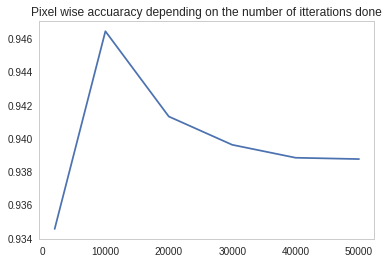

In [9]:
plt.plot(nb_itterations, accuaracy_depending_nbItterations)
plt.title("Pixel wise accuaracy depending on the number of itterations done")

In [ ]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)